# 02 — Analysis using NHGIS data

Load analysis-ready NHGIS data from `01_ingestion_NHGIS.ipynb` and run the **shared econometric pipeline** from `scripts/core_metrics.py` (OLS, HC3, WLS, log-level, diagnostics). Drivers and barriers of multigenerational living at tract level; no SFA.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

REPO_ROOT = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == "notebooks" else os.getcwd()
sys.path.insert(0, os.path.join(REPO_ROOT, "scripts"))
from core_metrics import run_ols_pipeline, FEATURE_LABELS

sns.set_theme(style="whitegrid", font_scale=1.05)
plt.rcParams["figure.dpi"] = 150

path_nhgis = os.path.join(REPO_ROOT, "data", "processed", "nhgis_analysis_ready.csv")
if not os.path.isfile(path_nhgis):
    raise FileNotFoundError("Run 01_ingestion_NHGIS.ipynb first")
df = pd.read_csv(path_nhgis)
print("Loaded:", df.shape)
print("Target variable (Multigen_Rate) summary:")
print(df["Multigen_Rate"].describe())

Loaded: (84529, 38)
Target variable (Multigen_Rate) summary:
count    84529.000000
mean         5.563484
std          4.387044
min          0.000000
25%          2.359232
50%          4.529717
75%          7.673943
max         68.699187
Name: Multigen_Rate, dtype: float64


## Run Econometric Pipeline

This calls `core_metrics.run_ols_pipeline()` which performs:
- Feature screening (correlation + VIF)
- OLS baseline + HC3 robust standard errors
- Weighted Least Squares (if weights available)
- Log-level robustness check
- Diagnostic tests (Breusch-Pagan, White, Jarque-Bera, Ramsey RESET)
- Coefficient and standardized (beta) tables

In [2]:
results = run_ols_pipeline(
    df, 
    target_col="Multigen_Rate", 
    weight_col="_total_hh" if "_total_hh" in df.columns else None
)

print("=" * 70)
print("MODEL RESULTS")
print("=" * 70)
print(f"OLS (Baseline) R²:        {results['ols_model'].rsquared:.4f}")
print(f"OLS (HC3 Robust) R²:       {results['ols_robust'].rsquared:.4f}")
print(f"OLS (HC3) Adj. R²:         {results['ols_robust'].rsquared_adj:.4f}")
print(f"OLS (HC3) F-statistic:     {results['ols_robust'].fvalue:.2f}")
print(f"OLS (HC3) Prob (F-stat):   {results['ols_robust'].f_pvalue:.2e}")
print(f"N observations:            {int(results['ols_robust'].nobs):,}")
print(f"Features retained:         {len(results['final_features'])}")
if results['wls_model'] is not None:
    print(f"WLS (Pop-Weighted) R²:    {results['wls_model'].rsquared:.4f}")
print(f"Log-Level R²:              {results['ols_log'].rsquared:.4f}")

MODEL RESULTS
OLS (Baseline) R²:        0.4762
OLS (HC3 Robust) R²:       0.4762
OLS (HC3) Adj. R²:         0.4760
OLS (HC3) F-statistic:     2242.16
OLS (HC3) Prob (F-stat):   0.00e+00
N observations:            84,279
Features retained:         28
WLS (Pop-Weighted) R²:    0.4844
Log-Level R²:              0.3863


## Diagnostic Tests

In [3]:
diag = results["diagnostics"]
print("Breusch-Pagan (heteroskedasticity):")
bp_lm, bp_pval = diag["breusch_pagan"]
print(f"  LM stat = {bp_lm:.2f}, p-value = {bp_pval:.4e}")
print(f"  → {'Heteroskedasticity detected' if bp_pval < 0.05 else 'Homoskedastic'} at 5% level")

print("\nJarque-Bera (normality):")
jb_stat, jb_pval, jb_skew, jb_kurtosis = diag["jarque_bera"]
print(f"  JB stat = {jb_stat:.2f}, p-value = {jb_pval:.4e}")
print(f"  Skewness = {jb_skew:.3f}, Kurtosis = {jb_kurtosis:.3f}")
print(f"  → {'Non-normal' if jb_pval < 0.05 else 'Normal'} residuals at 5% level")

if not np.isnan(diag["reset"][0]):
    reset_fstat, reset_pval = diag["reset"]
    print("\nRamsey RESET (functional form):")
    print(f"  F-stat = {reset_fstat:.2f}, p-value = {reset_pval:.4e}")
    print(f"  → {'Misspecification detected' if reset_pval < 0.05 else 'No misspecification'} at 5% level")

Breusch-Pagan (heteroskedasticity):
  LM stat = 8086.12, p-value = 0.0000e+00
  → Heteroskedasticity detected at 5% level

Jarque-Bera (normality):
  JB stat = 19370.71, p-value = 0.0000e+00
  Skewness = 0.776, Kurtosis = 4.762
  → Non-normal residuals at 5% level

Ramsey RESET (functional form):
  F-stat = 520.15, p-value = 3.0687e-225
  → Misspecification detected at 5% level


## Coefficient Estimates (Robust OLS, HC3)

Top 15 determinants sorted by absolute coefficient magnitude.

In [4]:
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.width", 140)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

display_cols = ["Label", "Robust_Coef", "Robust_SE", "Robust_pval", "Significance"]
results["coef_table"][display_cols].head(15)

,Label,Robust_Coef,Robust_SE,Robust_pval,Significance
8,Gini Index (Inequality),2.2432,0.2151,0.0000,***
16,% Married-Couple HH,-0.1157,0.0024,0.0000,***
15,% Family Households,0.1130,0.0025,0.0000,***
3,% Asian (Non-Hispanic),0.0631,0.0020,0.0000,***
5,% Foreign-Born,0.0515,0.0019,0.0000,***
17,% Bachelor's Degree or Higher,-0.0511,0.0013,0.0000,***
18,% Less Than High School,0.0503,0.0026,0.0000,***
7,Poverty Rate (%),-0.0380,0.0023,0.0000,***
11,% Mobile Homes,0.0372,0.0018,0.0000,***
4,% Black (Non-Hispanic),0.0361,0.0010,0.0000,***


## Standardized (Beta) Coefficients

Top 10 by absolute beta magnitude — allows comparison of relative importance across variables.

In [5]:
results["beta_table"][["Label", "Beta_Coef", "Beta_SE", "Beta_pval", "Significance"]].head(10)

,Label,Beta_Coef,Beta_SE,Beta_pval,Significance
16,% Married-Couple HH,-0.4629,0.0094,0.0000,***
15,% Family Households,0.3986,0.0087,0.0000,***
17,% Bachelor's Degree or Higher,-0.2393,0.0059,0.0000,***
2,% Hispanic/Latino,0.1940,0.0059,0.0000,***
4,% Black (Non-Hispanic),0.1692,0.0046,0.0000,***
5,% Foreign-Born,0.1656,0.0060,0.0000,***
3,% Asian (Non-Hispanic),0.1359,0.0043,0.0000,***
10,% Single-Family Homes,0.1200,0.0065,0.0000,***
18,% Less Than High School,0.1123,0.0059,0.0000,***
13,% Owner-Occupied,0.1041,0.0071,0.0000,***


## Visualizations

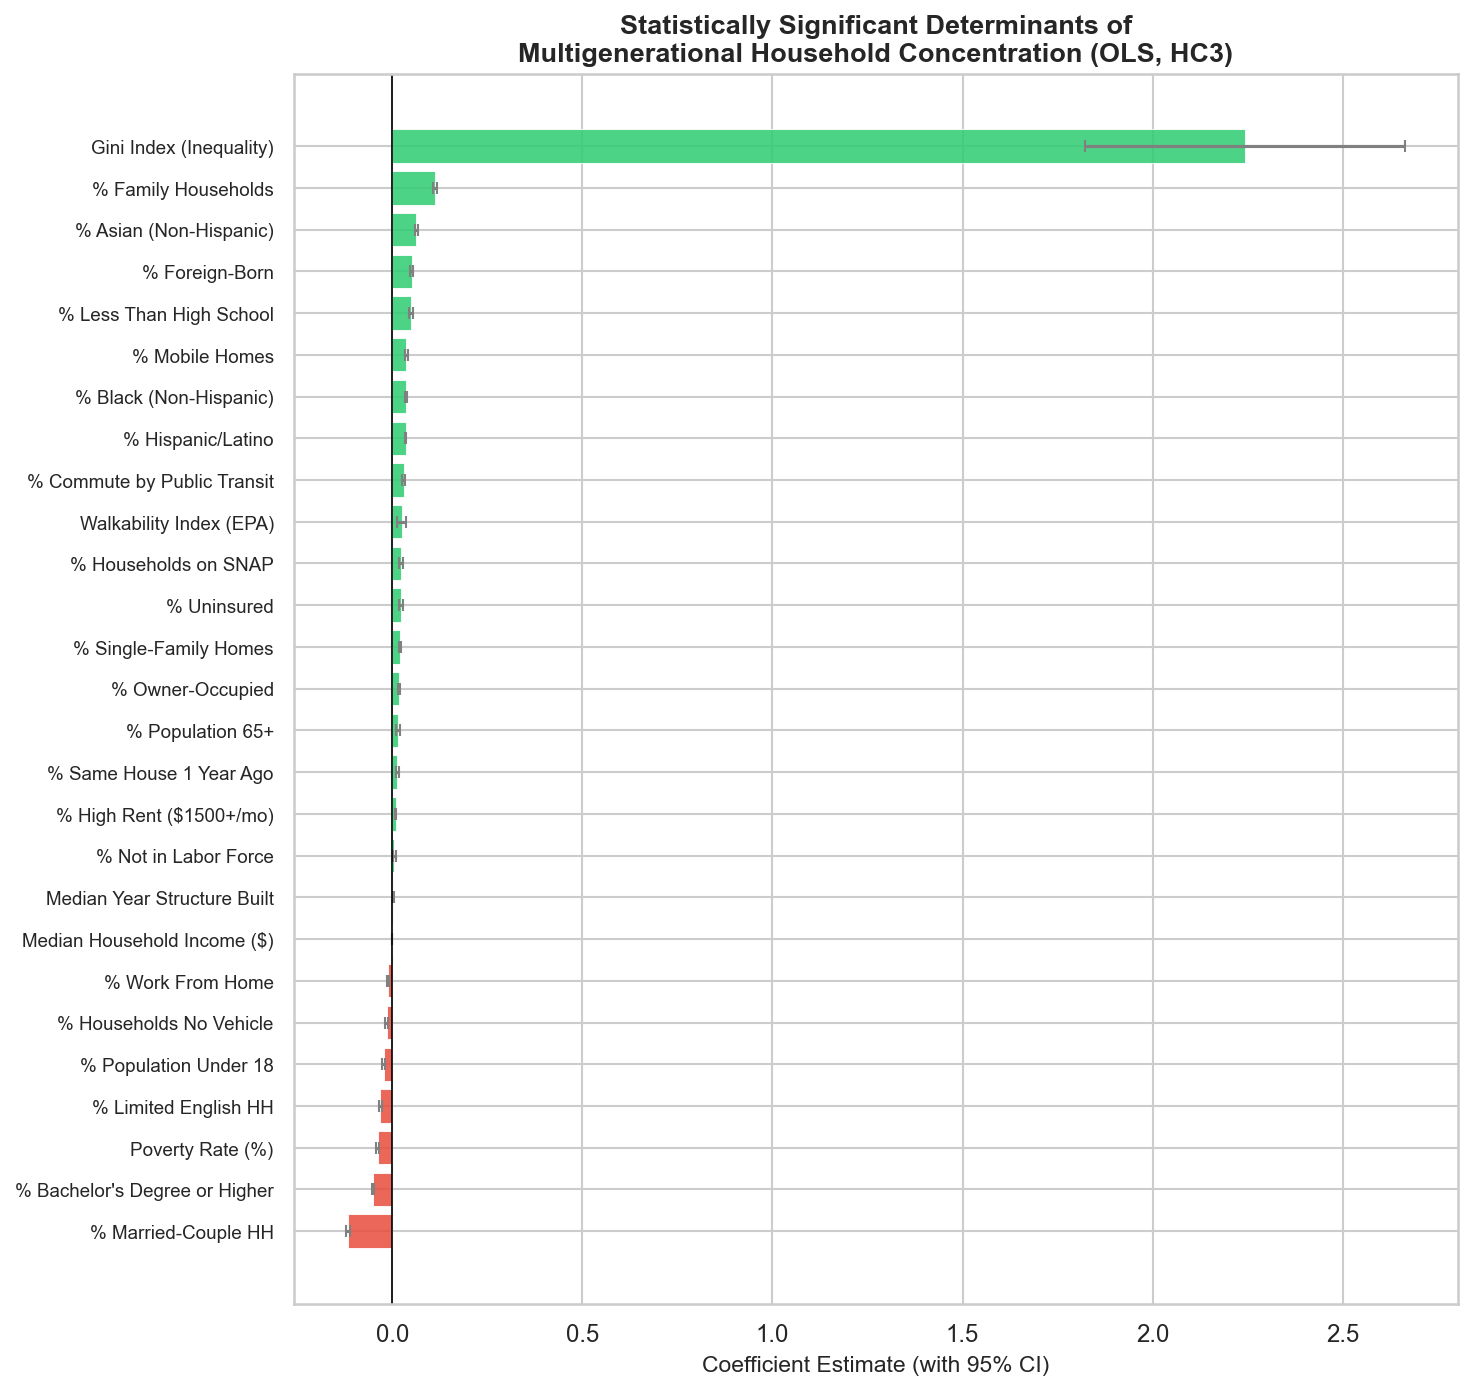

In [6]:
# Coefficient plot (significant features only)
sig_coefs = results["coef_table"][results["coef_table"]["Robust_pval"] < 0.05].copy()
sig_coefs = sig_coefs.sort_values("Robust_Coef")

fig, ax = plt.subplots(figsize=(10, max(6, len(sig_coefs) * 0.35)))
colors = ["#e74c3c" if c < 0 else "#2ecc71" for c in sig_coefs["Robust_Coef"]]
ax.barh(
    range(len(sig_coefs)), sig_coefs["Robust_Coef"],
    xerr=1.96 * sig_coefs["Robust_SE"],
    color=colors, edgecolor="white", linewidth=0.5,
    capsize=3, ecolor="gray", alpha=0.85,
)
ax.set_yticks(range(len(sig_coefs)))
ax.set_yticklabels(sig_coefs["Label"], fontsize=9)
ax.axvline(0, color="black", linewidth=0.8, linestyle="-")
ax.set_xlabel("Coefficient Estimate (with 95% CI)", fontsize=11)
ax.set_title("Statistically Significant Determinants of\nMultigenerational Household Concentration (OLS, HC3)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

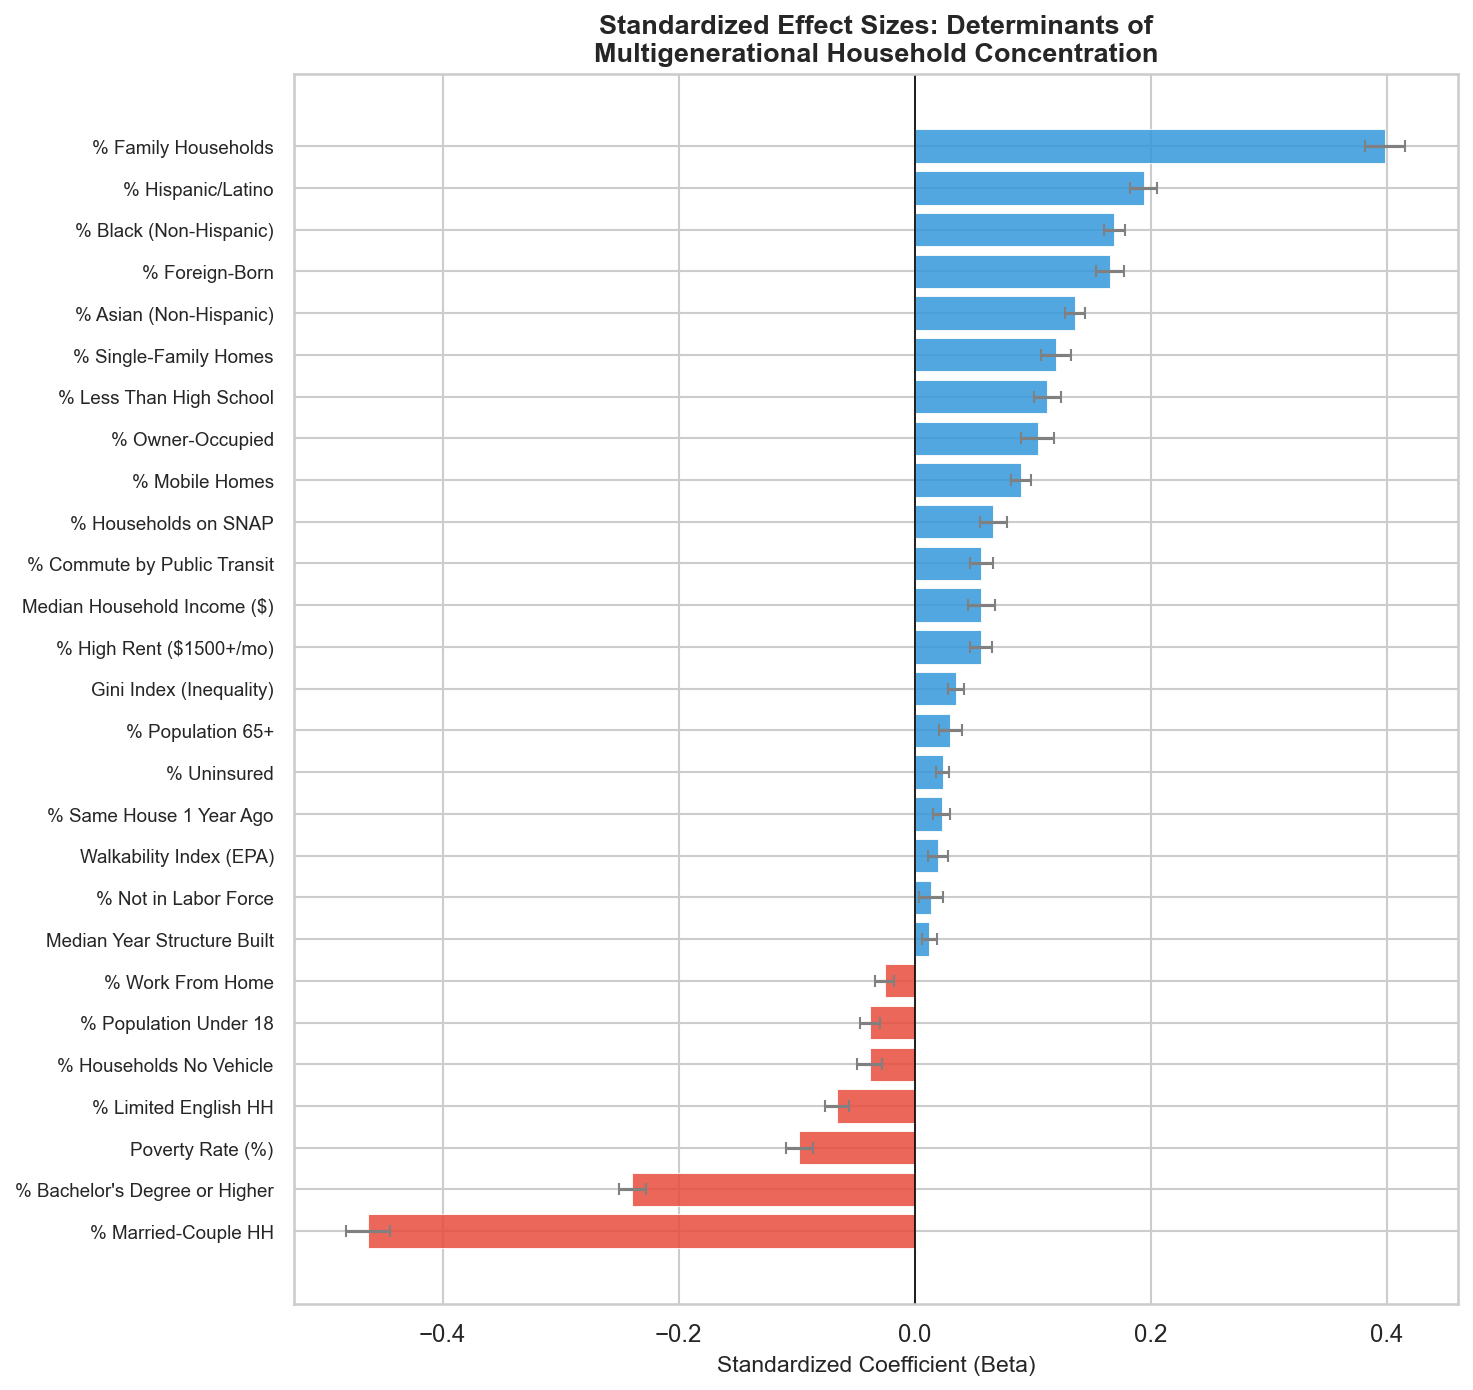

In [7]:
# Standardized beta plot
sig_betas = results["beta_table"][results["beta_table"]["Beta_pval"] < 0.05].copy()
sig_betas = sig_betas.sort_values("Beta_Coef")

fig, ax = plt.subplots(figsize=(10, max(6, len(sig_betas) * 0.35)))
colors = ["#e74c3c" if c < 0 else "#3498db" for c in sig_betas["Beta_Coef"]]
ax.barh(
    range(len(sig_betas)), sig_betas["Beta_Coef"],
    xerr=1.96 * sig_betas["Beta_SE"],
    color=colors, edgecolor="white", linewidth=0.5,
    capsize=3, ecolor="gray", alpha=0.85,
)
ax.set_yticks(range(len(sig_betas)))
ax.set_yticklabels(sig_betas["Label"], fontsize=9)
ax.axvline(0, color="black", linewidth=0.8, linestyle="-")
ax.set_xlabel("Standardized Coefficient (Beta)", fontsize=11)
ax.set_title("Standardized Effect Sizes: Determinants of\nMultigenerational Household Concentration",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

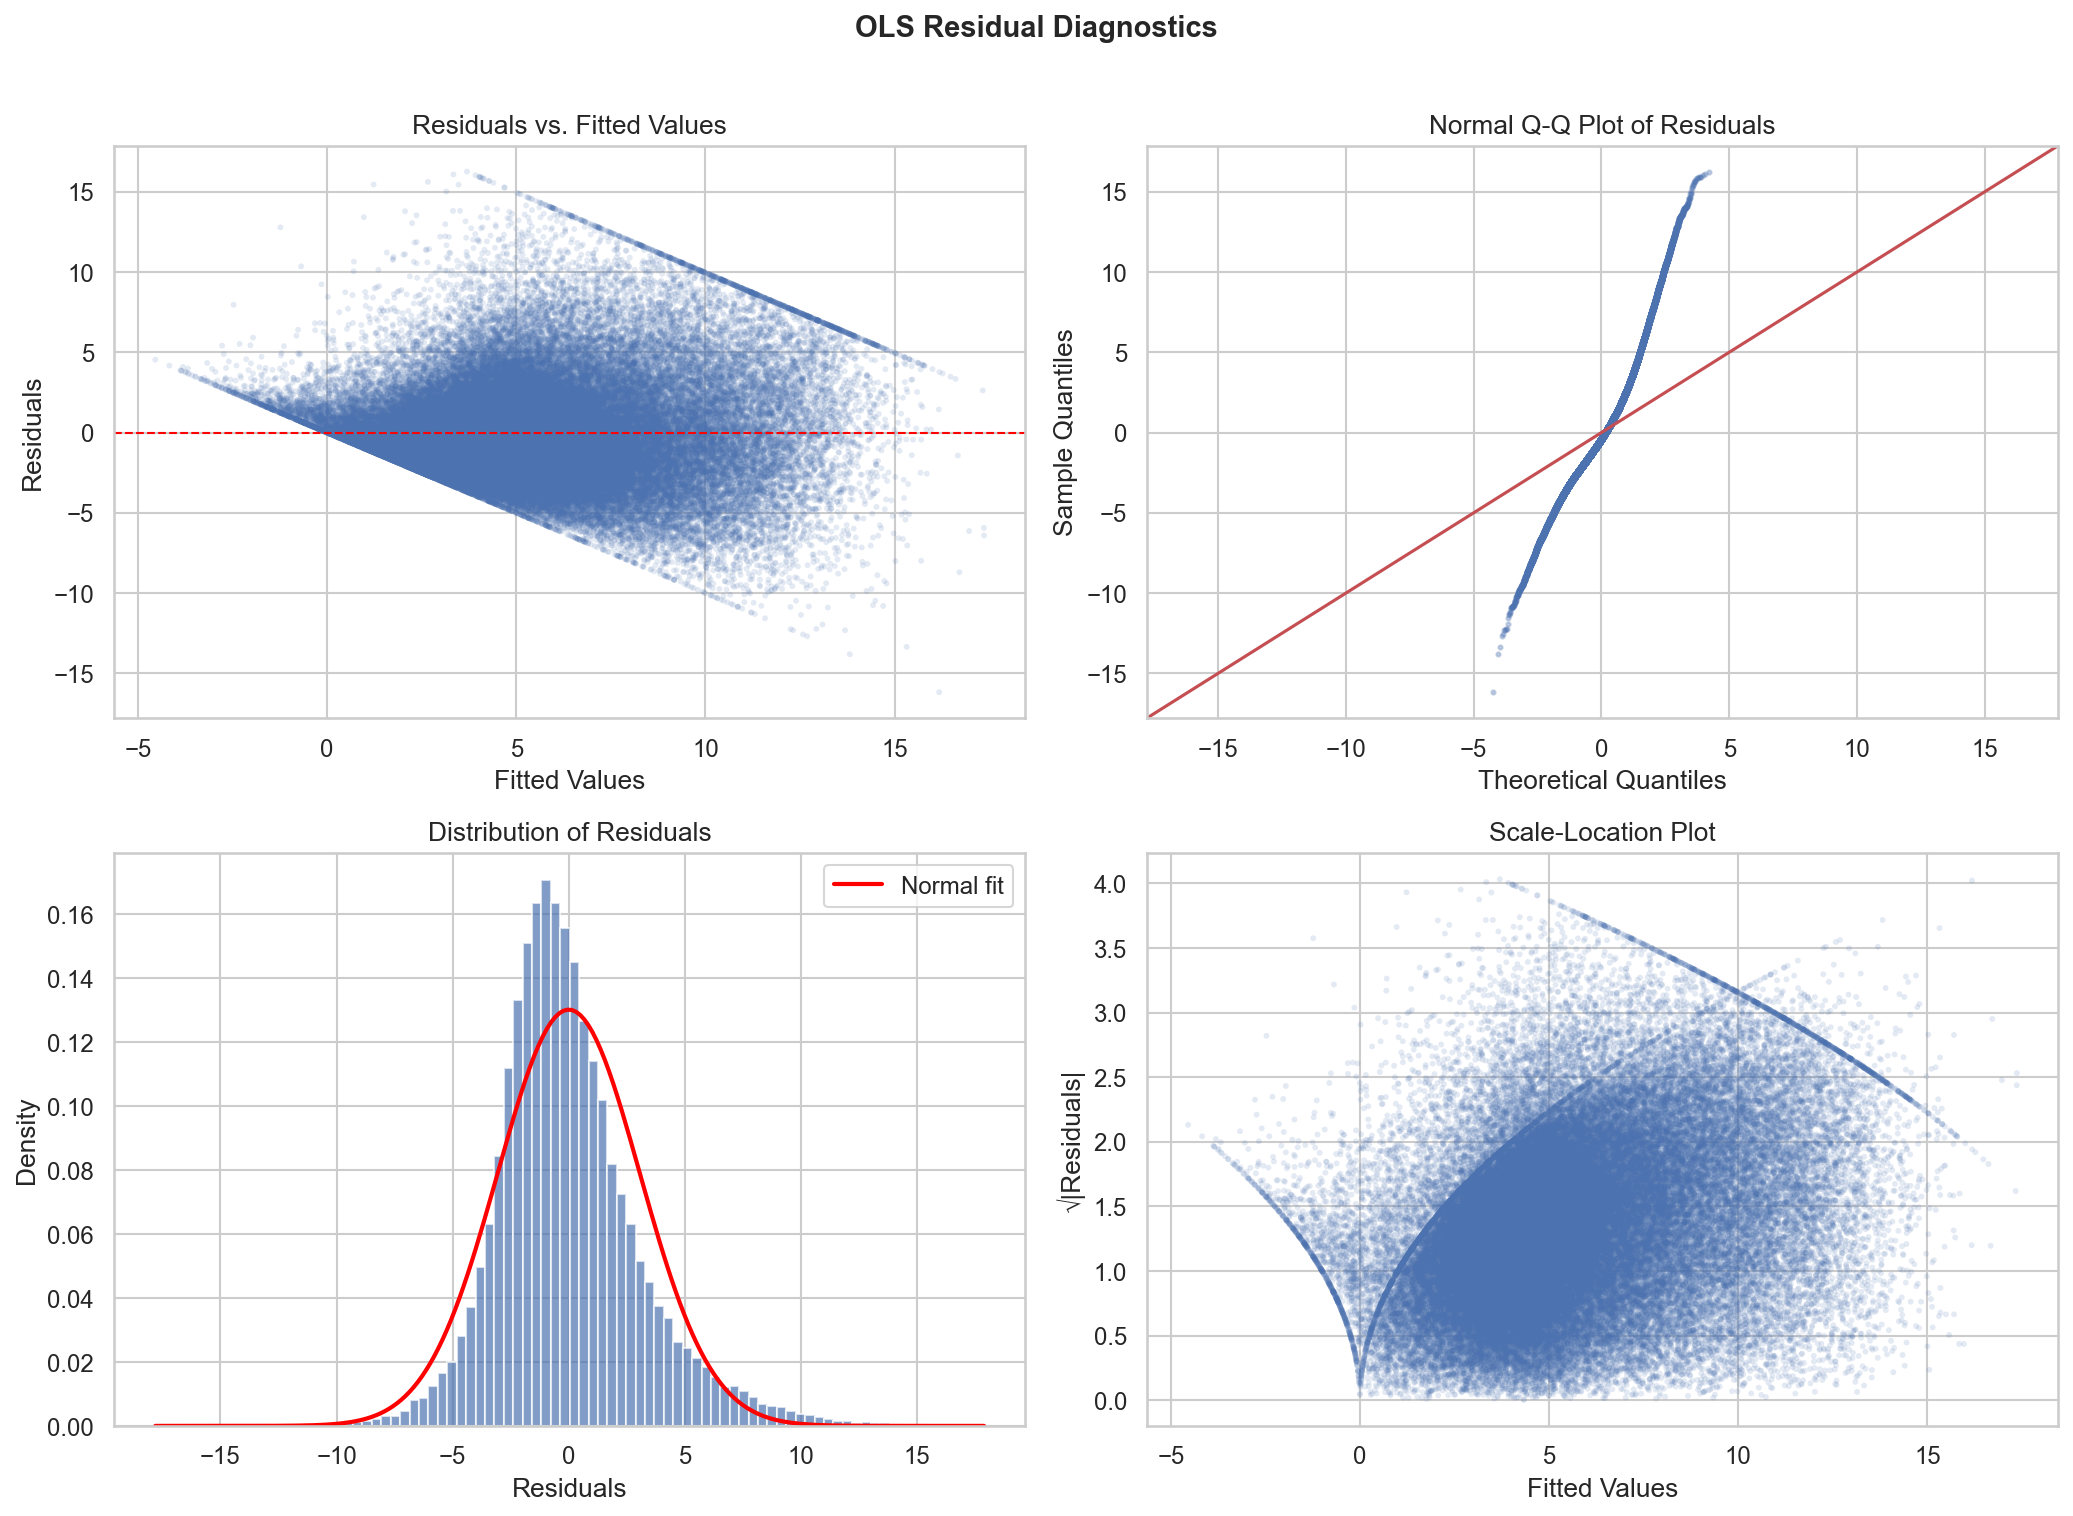

In [8]:
# Residual diagnostics
resid = results["ols_model"].resid
fitted = results["ols_model"].fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.scatter(fitted, resid, alpha=0.15, s=8, edgecolors="none")
ax.axhline(0, color="red", linewidth=1, linestyle="--")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs. Fitted Values")

import statsmodels.api as sm
ax = axes[0, 1]
sm.qqplot(resid, line="45", ax=ax, markersize=2, alpha=0.3)
ax.set_title("Normal Q-Q Plot of Residuals")

ax = axes[1, 0]
ax.hist(resid, bins=80, density=True, alpha=0.7, edgecolor="white")
from scipy.stats import norm
xmin, xmax = ax.get_xlim()
x_range = np.linspace(xmin, xmax, 200)
ax.plot(x_range, norm.pdf(x_range, resid.mean(), resid.std()),
        color="red", linewidth=2, label="Normal fit")
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")
ax.set_title("Distribution of Residuals")
ax.legend()

ax = axes[1, 1]
sqrt_abs_resid = np.sqrt(np.abs(resid))
ax.scatter(fitted, sqrt_abs_resid, alpha=0.15, s=8, edgecolors="none")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("√|Residuals|")
ax.set_title("Scale-Location Plot")

plt.suptitle("OLS Residual Diagnostics", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

## Save Results

Save coefficient and beta tables for comparison with AHS/ASEC results.

In [9]:
OUTPUT_DIR = os.path.join(REPO_ROOT, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

results["coef_table"].to_csv(os.path.join(OUTPUT_DIR, "nhgis_coefficient_table.csv"), index=False)
results["beta_table"].to_csv(os.path.join(OUTPUT_DIR, "nhgis_standardized_coefficients.csv"), index=False)

print(f"Saved coefficient table: {OUTPUT_DIR}/nhgis_coefficient_table.csv")
print(f"Saved standardized coefficients: {OUTPUT_DIR}/nhgis_standardized_coefficients.csv")

Saved coefficient table: /Users/elyas/vscode/capstone_multigen_housing_econometric_analysis/output/nhgis_coefficient_table.csv
Saved standardized coefficients: /Users/elyas/vscode/capstone_multigen_housing_econometric_analysis/output/nhgis_standardized_coefficients.csv
